# 02 - Disease Prevalence Analysis

This notebook analyzes disease prevalence and patient characteristics for target conditions in MIMIC-IV.

## Objectives
1. Count patients and admissions per disease
2. Analyze demographics (age, gender) by disease
3. Calculate mortality rates
4. Assess class balance
5. Visualize findings

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path
from datetime import datetime

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

## 1. Setup and Data Loading

In [2]:
# Set paths
DATA_DIR = Path('../data/raw')
CONFIG_DIR = Path('../configs')
OUTPUT_DIR = Path('../experiments')

# Create output directory
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Data directory exists: {DATA_DIR.exists()}")
print(f"Config directory: {CONFIG_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Data directory: ..\data\raw
Data directory exists: True
Config directory: ..\configs
Output directory: ..\experiments


In [3]:
# Helper function to load parquet files from a subdirectory
def load_table(table_name, verbose=True):
    """
    Load all parquet files from a table subdirectory into a single DataFrame.
    
    Args:
        table_name: Name of the table subdirectory
        verbose: Print loading information
    
    Returns:
        DataFrame or None if not found
    """
    table_dir = DATA_DIR / table_name
    if not table_dir.exists():
        if verbose:
            print(f"⚠️  Directory not found: {table_dir}")
        return None
    
    parquet_files = list(table_dir.glob("*.parquet"))
    if not parquet_files:
        if verbose:
            print(f"⚠️  No parquet files found in {table_dir}")
        return None
    
    # Load all parquet files and concatenate
    dfs = [pd.read_parquet(f) for f in parquet_files]
    df = pd.concat(dfs, ignore_index=True)
    
    if verbose:
        total_size_mb = sum(f.stat().st_size for f in parquet_files) / (1024 ** 2)
        print(f"✓ Loaded {table_name}: {len(df):,} rows from {len(parquet_files)} file(s) ({total_size_mb:.1f} MB)")
    
    return df

In [4]:
# Load configuration files
with open(CONFIG_DIR / 'diseases.yaml', 'r') as f:
    diseases_config = yaml.safe_load(f)

with open(CONFIG_DIR / 'cbc_features.yaml', 'r') as f:
    cbc_config = yaml.safe_load(f)

print(f"Loaded {len(diseases_config['diseases'])} disease definitions")
print(f"Loaded {len(cbc_config['cbc_features'])} CBC features")

# Display target diseases
print("\nTarget Diseases:")
for disease_key, disease_info in diseases_config['diseases'].items():
    icd9_count = len(disease_info.get('icd9_codes', []))
    icd10_count = len(disease_info.get('icd10_codes', []))
    print(f"  • {disease_info['name']:30s} (ICD-9: {icd9_count}, ICD-10: {icd10_count})")

Loaded 5 disease definitions
Loaded 15 CBC features

Target Diseases:
  • Rheumatoid Arthritis           (ICD-9: 7, ICD-10: 2)
  • Diabetes Mellitus Type 1       (ICD-9: 6, ICD-10: 1)
  • Diabetes Mellitus Type 2       (ICD-9: 6, ICD-10: 1)
  • Crohn's Disease                (ICD-9: 4, ICD-10: 1)
  • Psoriasis                      (ICD-9: 1, ICD-10: 1)


In [5]:
# Load required tables
print("Loading MIMIC-IV tables...\n")

patients = load_table('patients')
admissions = load_table('admissions')
diagnoses = load_table('diagnoses_icd')
d_icd_diagnoses = load_table('d_icd_diagnoses')

# Check if data loaded successfully
DATA_AVAILABLE = all([df is not None for df in [patients, admissions, diagnoses]])

if DATA_AVAILABLE:
    print("\n✓ All required data loaded successfully")
    print(f"\nDataset sizes:")
    print(f"  Patients: {len(patients):,}")
    print(f"  Admissions: {len(admissions):,}")
    print(f"  Diagnoses: {len(diagnoses):,}")
else:
    print("\n⚠️  Some data not available. Please ensure MIMIC-IV data is downloaded.")

Loading MIMIC-IV tables...

✓ Loaded patients: 364,627 rows from 1 file(s) (2.5 MB)
✓ Loaded admissions: 546,028 rows from 1 file(s) (22.1 MB)
✓ Loaded diagnoses_icd: 6,364,488 rows from 1 file(s) (57.6 MB)
✓ Loaded d_icd_diagnoses: 112,107 rows from 1 file(s) (1.9 MB)

✓ All required data loaded successfully

Dataset sizes:
  Patients: 364,627
  Admissions: 546,028
  Diagnoses: 6,364,488


## 2. Disease Identification Functions

In [6]:
def get_disease_patients(disease_config, diagnoses_df):
    """
    Find all patients and admissions with a specific disease.
    
    Args:
        disease_config: Disease configuration dict with icd9_codes and icd10_codes
        diagnoses_df: Diagnoses DataFrame
    
    Returns:
        dict with patient_ids, admission_ids, and diagnosis records
    """
    icd_codes = disease_config.get('icd9_codes', []) + disease_config.get('icd10_codes', [])
    
    # Create mask for any ICD code matching the disease
    mask = diagnoses_df['icd_code'].str.startswith(tuple(icd_codes))
    disease_diagnoses = diagnoses_df[mask]
    
    return {
        'patient_ids': disease_diagnoses['subject_id'].unique(),
        'admission_ids': disease_diagnoses['hadm_id'].unique(),
        'diagnoses': disease_diagnoses
    }

def analyze_disease_demographics(disease_data, patients_df, admissions_df):
    """
    Analyze demographics for patients with a specific disease.
    
    Args:
        disease_data: Output from get_disease_patients()
        patients_df: Patients DataFrame
        admissions_df: Admissions DataFrame
    
    Returns:
        dict with demographic statistics
    """
    patient_ids = disease_data['patient_ids']
    admission_ids = disease_data['admission_ids']
    
    # Get patient demographics
    disease_patients = patients_df[patients_df['subject_id'].isin(patient_ids)]
    disease_admissions = admissions_df[admissions_df['hadm_id'].isin(admission_ids)]
    
    # Calculate statistics
    total_patients = len(patient_ids)
    total_admissions = len(admission_ids)
    
    # Age distribution (at anchor year)
    ages = disease_patients['anchor_age']
    avg_age = ages.mean()
    median_age = ages.median()
    std_age = ages.std()
    
    # Gender distribution
    gender_counts = disease_patients['gender'].value_counts()
    pct_female = (gender_counts.get('F', 0) / total_patients * 100) if total_patients > 0 else 0
    pct_male = (gender_counts.get('M', 0) / total_patients * 100) if total_patients > 0 else 0
    
    # Mortality rate (hospital deaths)
    deaths = disease_admissions['hospital_expire_flag'].sum()
    mortality_rate = (deaths / total_admissions * 100) if total_admissions > 0 else 0
    
    return {
        'total_patients': total_patients,
        'total_admissions': total_admissions,
        'avg_age': avg_age,
        'median_age': median_age,
        'std_age': std_age,
        'age_values': ages.values,
        'pct_female': pct_female,
        'pct_male': pct_male,
        'deaths': deaths,
        'mortality_rate': mortality_rate,
        'patients': disease_patients,
        'admissions': disease_admissions
    }

print("✓ Disease analysis functions defined")

✓ Disease analysis functions defined


## 3. Analyze Each Disease

In [7]:
if DATA_AVAILABLE:
    # Analyze all diseases
    disease_results = {}
    
    print("Analyzing disease prevalence and demographics...\n")
    print("=" * 80)
    
    for disease_key, disease_config in diseases_config['diseases'].items():
        disease_name = disease_config['name']
        print(f"\n{disease_name}")
        print("-" * 80)
        
        # Get disease data
        disease_data = get_disease_patients(disease_config, diagnoses)
        
        # Analyze demographics
        stats = analyze_disease_demographics(disease_data, patients, admissions)
        
        # Store results
        disease_results[disease_key] = {
            'name': disease_name,
            'config': disease_config,
            **stats
        }
        
        # Print summary
        print(f"  Total Patients:        {stats['total_patients']:>8,}")
        print(f"  Total Admissions:      {stats['total_admissions']:>8,}")
        print(f"  Avg Age:               {stats['avg_age']:>8.1f} years")
        print(f"  Median Age:            {stats['median_age']:>8.1f} years")
        print(f"  Gender - Female:       {stats['pct_female']:>8.1f}%")
        print(f"  Gender - Male:         {stats['pct_male']:>8.1f}%")
        print(f"  Hospital Deaths:       {stats['deaths']:>8,}")
        print(f"  Mortality Rate:        {stats['mortality_rate']:>8.2f}%")
    
    print("\n" + "=" * 80)
    print("✓ Disease analysis complete")
else:
    print("⚠️  Cannot perform analysis - data not available")

Analyzing disease prevalence and demographics...


Rheumatoid Arthritis
--------------------------------------------------------------------------------
  Total Patients:           2,120
  Total Admissions:         4,345
  Avg Age:                   65.1 years
  Median Age:                66.0 years
  Gender - Female:           74.2%
  Gender - Male:             25.8%
  Hospital Deaths:            110
  Mortality Rate:            2.53%

Diabetes Mellitus Type 1
--------------------------------------------------------------------------------
  Total Patients:           1,762
  Total Admissions:         4,364
  Avg Age:                   48.3 years
  Median Age:                49.0 years
  Gender - Female:           51.5%
  Gender - Male:             48.5%
  Hospital Deaths:             83
  Mortality Rate:            1.90%

Diabetes Mellitus Type 2
--------------------------------------------------------------------------------
  Total Patients:          26,344
  Total Admissions:      

## 4. Summary Table

In [8]:
if DATA_AVAILABLE:
    # Create summary table
    summary_data = []
    
    for disease_key, result in disease_results.items():
        summary_data.append({
            'Disease': result['name'],
            'Patients': result['total_patients'],
            'Admissions': result['total_admissions'],
            'Avg Age': result['avg_age'],
            'Median Age': result['median_age'],
            '% Female': result['pct_female'],
            '% Male': result['pct_male'],
            'Deaths': result['deaths'],
            '% Mortality': result['mortality_rate']
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('Patients', ascending=False)
    
    print("\n📊 DISEASE PREVALENCE SUMMARY TABLE")
    print("=" * 100)
    display(summary_df)
    
    # Save to CSV
    output_path = OUTPUT_DIR / 'disease_prevalence_summary.csv'
    summary_df.to_csv(output_path, index=False)
    print(f"\n✓ Summary table saved to: {output_path}")
else:
    print("⚠️  Cannot create summary - data not available")


📊 DISEASE PREVALENCE SUMMARY TABLE


,Disease,Patients,Admissions,Avg Age,Median Age,% Female,% Male,Deaths,% Mortality
2,Diabetes Mellitus Type 2,26344,60991,64.99,66.00,44.93,55.07,1924,3.15
0,Rheumatoid Arthritis,2120,4345,65.15,66.00,74.20,25.80,110,2.53
1,Diabetes Mellitus Type 1,1762,4364,48.31,49.00,51.48,48.52,83,1.90
4,Psoriasis,1490,2496,60.29,62.00,45.70,54.30,64,2.56
3,Crohn's Disease,1367,3021,50.53,51.00,54.35,45.65,28,0.93



✓ Summary table saved to: ..\experiments\disease_prevalence_summary.csv


## 5. Visualizations

### 5.1 Patient and Admission Counts by Disease

✓ Saved: ..\experiments\disease_prevalence_counts.png


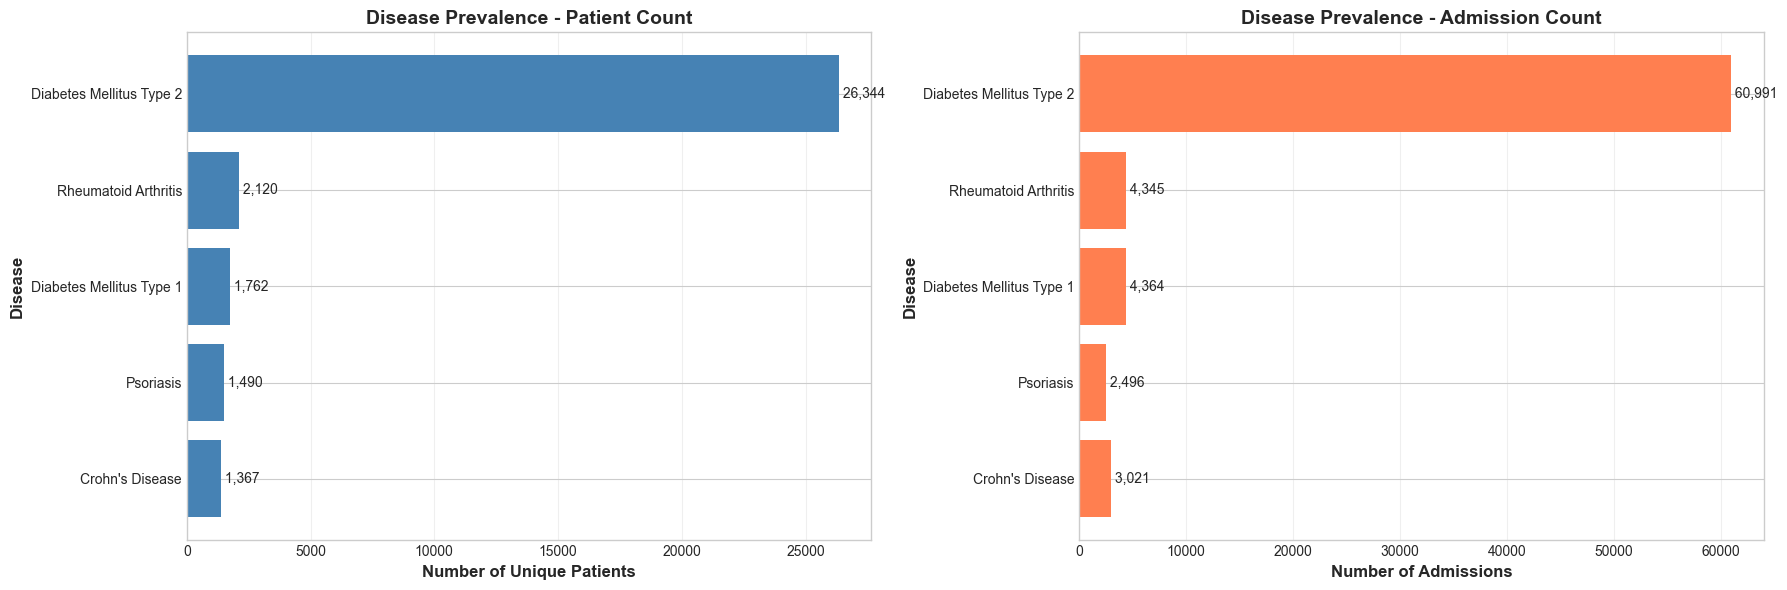

In [9]:
if DATA_AVAILABLE:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Sort by patient count for consistent ordering
    summary_sorted = summary_df.sort_values('Patients', ascending=True)
    
    # Plot 1: Patient counts
    ax1.barh(summary_sorted['Disease'], summary_sorted['Patients'], color='steelblue')
    ax1.set_xlabel('Number of Unique Patients', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Disease', fontsize=12, fontweight='bold')
    ax1.set_title('Disease Prevalence - Patient Count', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(summary_sorted['Patients']):
        ax1.text(v, i, f' {v:,}', va='center', fontsize=10)
    
    # Plot 2: Admission counts
    ax2.barh(summary_sorted['Disease'], summary_sorted['Admissions'], color='coral')
    ax2.set_xlabel('Number of Admissions', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Disease', fontsize=12, fontweight='bold')
    ax2.set_title('Disease Prevalence - Admission Count', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(summary_sorted['Admissions']):
        ax2.text(v, i, f' {v:,}', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'disease_prevalence_counts.png', dpi=150, bbox_inches='tight')
    print(f"✓ Saved: {OUTPUT_DIR / 'disease_prevalence_counts.png'}")
    plt.show()
else:
    print("⚠️  Cannot create visualization - data not available")

### 5.2 Age Distribution by Disease

✓ Saved: ..\experiments\disease_age_distributions.png


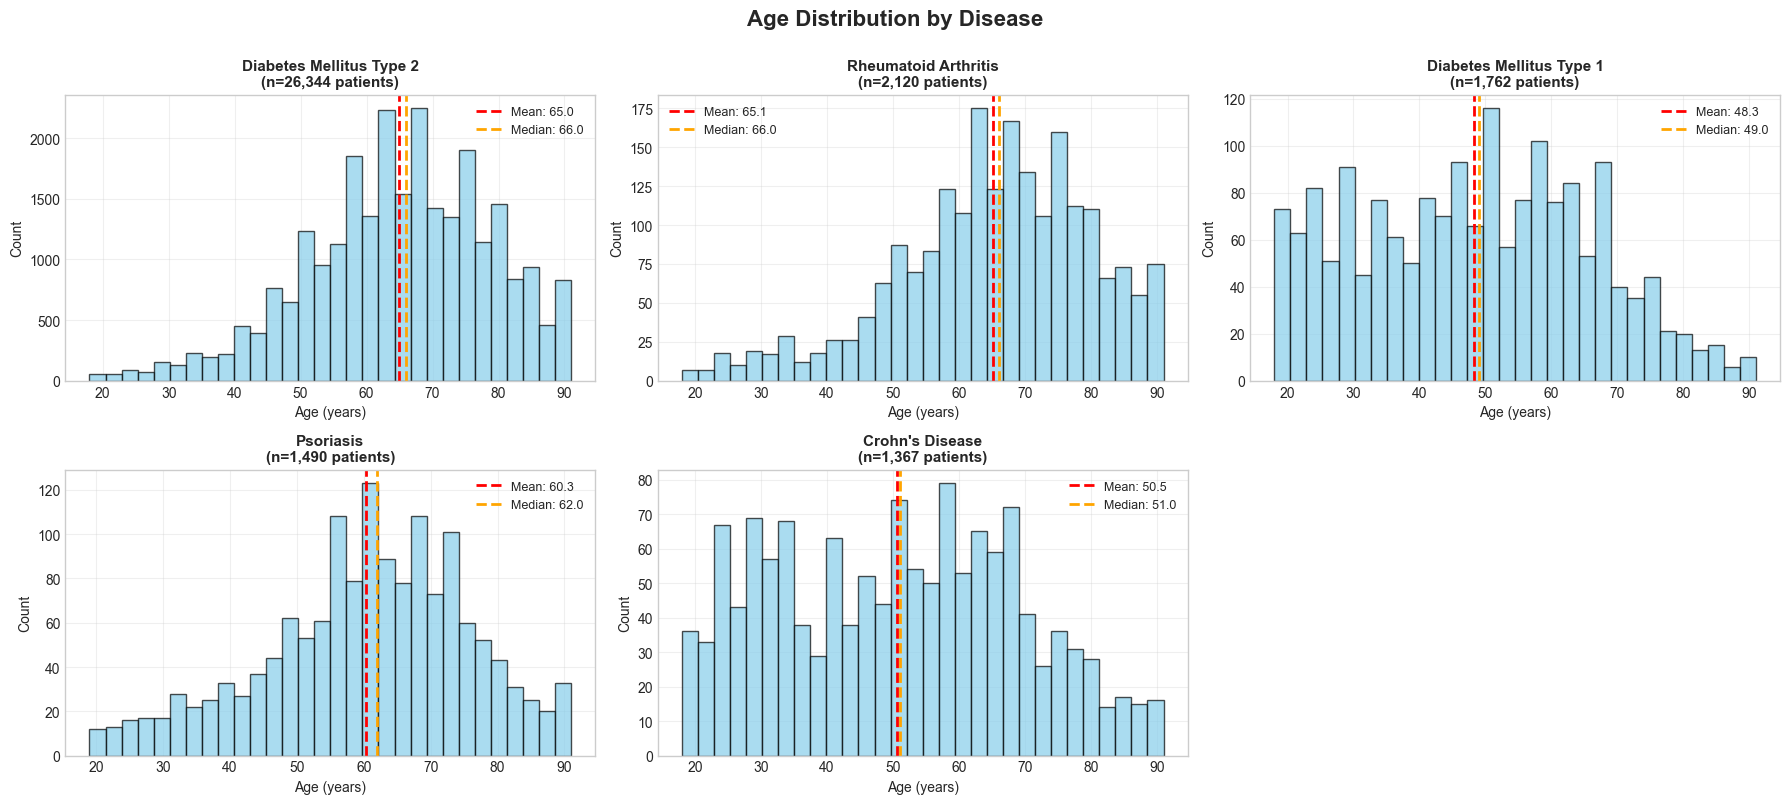

In [10]:
if DATA_AVAILABLE:
    # Determine grid size
    n_diseases = len(disease_results)
    n_cols = 3
    n_rows = (n_diseases + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    # Sort diseases by patient count for consistent ordering
    sorted_diseases = sorted(disease_results.items(), 
                           key=lambda x: x[1]['total_patients'], 
                           reverse=True)
    
    for idx, (disease_key, result) in enumerate(sorted_diseases):
        ax = axes[idx]
        ages = result['age_values']
        
        # Plot histogram
        ax.hist(ages, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
        
        # Add mean and median lines
        ax.axvline(result['avg_age'], color='red', linestyle='--', linewidth=2, 
                  label=f"Mean: {result['avg_age']:.1f}")
        ax.axvline(result['median_age'], color='orange', linestyle='--', linewidth=2, 
                  label=f"Median: {result['median_age']:.1f}")
        
        ax.set_title(f"{result['name']}\n(n={result['total_patients']:,} patients)", 
                    fontsize=11, fontweight='bold')
        ax.set_xlabel('Age (years)', fontsize=10)
        ax.set_ylabel('Count', fontsize=10)
        ax.legend(fontsize=9)
        ax.grid(alpha=0.3)
    
    # Hide empty subplots
    for idx in range(n_diseases, len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Age Distribution by Disease', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'disease_age_distributions.png', dpi=150, bbox_inches='tight')
    print(f"✓ Saved: {OUTPUT_DIR / 'disease_age_distributions.png'}")
    plt.show()
else:
    print("⚠️  Cannot create visualization - data not available")

### 5.3 Gender and Mortality Comparison

✓ Saved: ..\experiments\disease_demographics.png


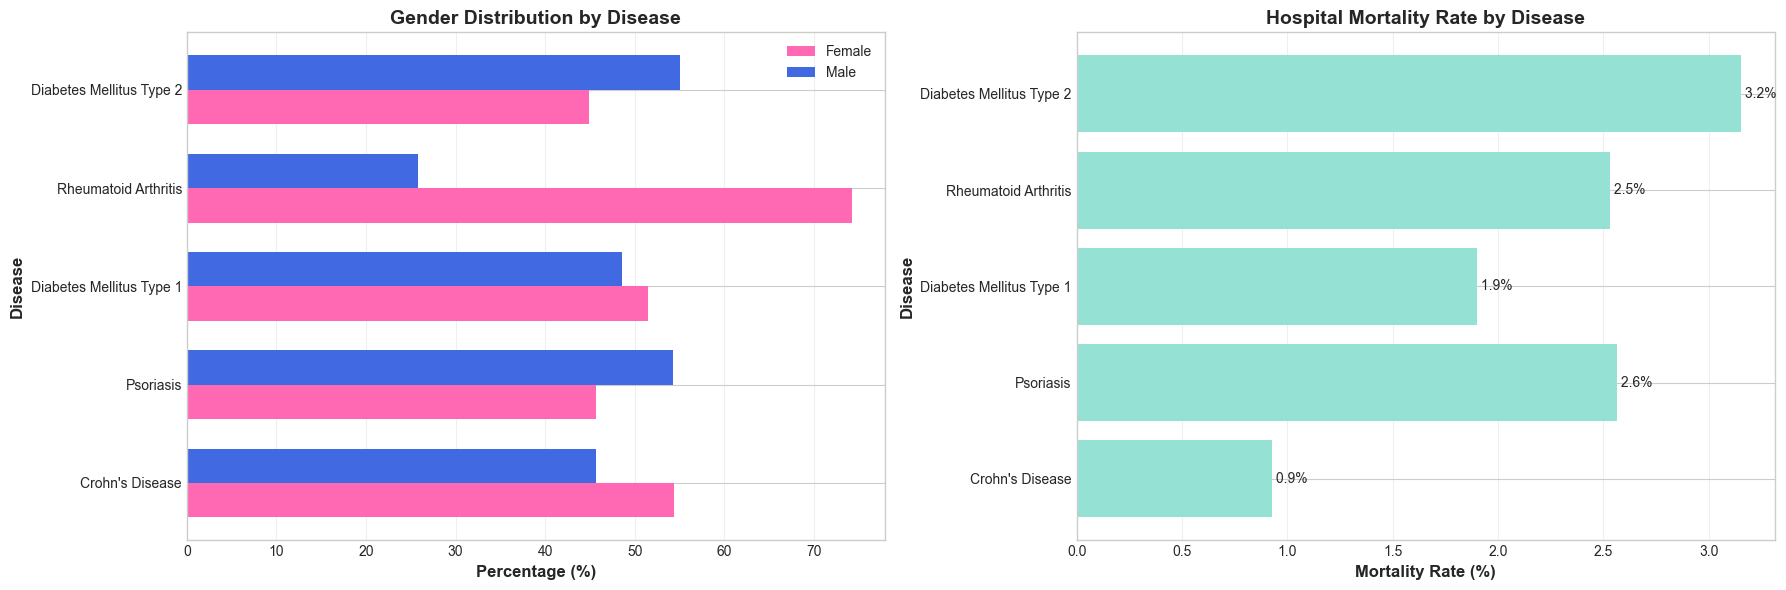

In [11]:
if DATA_AVAILABLE:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Sort by patient count
    summary_sorted = summary_df.sort_values('Patients', ascending=True)
    
    # Plot 1: Gender distribution
    x = np.arange(len(summary_sorted))
    width = 0.35
    
    ax1.barh(x - width/2, summary_sorted['% Female'], width, label='Female', color='#FF69B4')
    ax1.barh(x + width/2, summary_sorted['% Male'], width, label='Male', color='#4169E1')
    
    ax1.set_yticks(x)
    ax1.set_yticklabels(summary_sorted['Disease'])
    ax1.set_xlabel('Percentage (%)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Disease', fontsize=12, fontweight='bold')
    ax1.set_title('Gender Distribution by Disease', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(axis='x', alpha=0.3)
    
    # Plot 2: Mortality rates
    colors = ['#FF6B6B' if x > 15 else '#4ECDC4' if x > 10 else '#95E1D3' 
             for x in summary_sorted['% Mortality']]
    
    ax2.barh(summary_sorted['Disease'], summary_sorted['% Mortality'], color=colors)
    ax2.set_xlabel('Mortality Rate (%)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Disease', fontsize=12, fontweight='bold')
    ax2.set_title('Hospital Mortality Rate by Disease', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(summary_sorted['% Mortality']):
        ax2.text(v, i, f' {v:.1f}%', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'disease_demographics.png', dpi=150, bbox_inches='tight')
    print(f"✓ Saved: {OUTPUT_DIR / 'disease_demographics.png'}")
    plt.show()
else:
    print("⚠️  Cannot create visualization - data not available")

## 6. Class Balance Analysis

### 6.1 Disease vs Non-Disease Class Balance

In [12]:
if DATA_AVAILABLE:
    print("\n📊 CLASS BALANCE ANALYSIS")
    print("=" * 80)
    print(f"\nTotal patients in dataset: {len(patients):,}")
    print(f"Total admissions in dataset: {len(admissions):,}")
    print("\n" + "-" * 80)
    
    balance_data = []
    
    for disease_key, result in sorted(disease_results.items(), 
                                     key=lambda x: x[1]['total_patients'], 
                                     reverse=True):
        disease_name = result['name']
        positive_patients = result['total_patients']
        positive_admissions = result['total_admissions']
        
        negative_patients = len(patients) - positive_patients
        negative_admissions = len(admissions) - positive_admissions
        
        patient_ratio = positive_patients / negative_patients if negative_patients > 0 else 0
        admission_ratio = positive_admissions / negative_admissions if negative_admissions > 0 else 0
        
        patient_prevalence = (positive_patients / len(patients) * 100) if len(patients) > 0 else 0
        admission_prevalence = (positive_admissions / len(admissions) * 100) if len(admissions) > 0 else 0
        
        balance_data.append({
            'Disease': disease_name,
            'Positive Patients': positive_patients,
            'Negative Patients': negative_patients,
            'Patient Ratio (Pos:Neg)': f'1:{negative_patients/positive_patients:.1f}' if positive_patients > 0 else 'N/A',
            'Patient Prevalence (%)': patient_prevalence,
            'Positive Admissions': positive_admissions,
            'Negative Admissions': negative_admissions,
            'Admission Ratio (Pos:Neg)': f'1:{negative_admissions/positive_admissions:.1f}' if positive_admissions > 0 else 'N/A',
            'Admission Prevalence (%)': admission_prevalence
        })
        
        print(f"\n{disease_name}")
        print(f"  Patient-level:")
        print(f"    Positive (disease):     {positive_patients:>8,}  ({patient_prevalence:>5.2f}%)")
        print(f"    Negative (no disease):  {negative_patients:>8,}  ({100-patient_prevalence:>5.2f}%)")
        print(f"    Class ratio (pos:neg):  1:{negative_patients/positive_patients:,.1f}" if positive_patients > 0 else "    Class ratio: N/A")
        print(f"  Admission-level:")
        print(f"    Positive (disease):     {positive_admissions:>8,}  ({admission_prevalence:>5.2f}%)")
        print(f"    Negative (no disease):  {negative_admissions:>8,}  ({100-admission_prevalence:>5.2f}%)")
        print(f"    Class ratio (pos:neg):  1:{negative_admissions/positive_admissions:,.1f}" if positive_admissions > 0 else "    Class ratio: N/A")
    
    # Create balance summary DataFrame
    balance_df = pd.DataFrame(balance_data)
    
    print("\n" + "=" * 80)
    print("\n📊 CLASS BALANCE SUMMARY TABLE")
    display(balance_df)
    
    # Save to CSV
    output_path = OUTPUT_DIR / 'class_balance_analysis.csv'
    balance_df.to_csv(output_path, index=False)
    print(f"\n✓ Class balance analysis saved to: {output_path}")
else:
    print("⚠️  Cannot perform class balance analysis - data not available")


📊 CLASS BALANCE ANALYSIS

Total patients in dataset: 364,627
Total admissions in dataset: 546,028

--------------------------------------------------------------------------------

Diabetes Mellitus Type 2
  Patient-level:
    Positive (disease):       26,344  ( 7.22%)
    Negative (no disease):   338,283  (92.78%)
    Class ratio (pos:neg):  1:12.8
  Admission-level:
    Positive (disease):       60,991  (11.17%)
    Negative (no disease):   485,037  (88.83%)
    Class ratio (pos:neg):  1:8.0

Rheumatoid Arthritis
  Patient-level:
    Positive (disease):        2,120  ( 0.58%)
    Negative (no disease):   362,507  (99.42%)
    Class ratio (pos:neg):  1:171.0
  Admission-level:
    Positive (disease):        4,345  ( 0.80%)
    Negative (no disease):   541,683  (99.20%)
    Class ratio (pos:neg):  1:124.7

Diabetes Mellitus Type 1
  Patient-level:
    Positive (disease):        1,762  ( 0.48%)
    Negative (no disease):   362,865  (99.52%)
    Class ratio (pos:neg):  1:205.9
  Admissi

,Disease,Positive Patients,Negative Patients,Patient Ratio (Pos:Neg),Patient Prevalence (%),Positive Admissions,Negative Admissions,Admission Ratio (Pos:Neg),Admission Prevalence (%)
0,Diabetes Mellitus Type 2,26344,338283,1:12.8,7.22,60991,485037,1:8.0,11.17
1,Rheumatoid Arthritis,2120,362507,1:171.0,0.58,4345,541683,1:124.7,0.80
2,Diabetes Mellitus Type 1,1762,362865,1:205.9,0.48,4364,541664,1:124.1,0.80
3,Psoriasis,1490,363137,1:243.7,0.41,2496,543532,1:217.8,0.46
4,Crohn's Disease,1367,363260,1:265.7,0.37,3021,543007,1:179.7,0.55



✓ Class balance analysis saved to: ..\experiments\class_balance_analysis.csv


### 6.2 Visualize Class Imbalance

✓ Saved: ..\experiments\class_imbalance.png


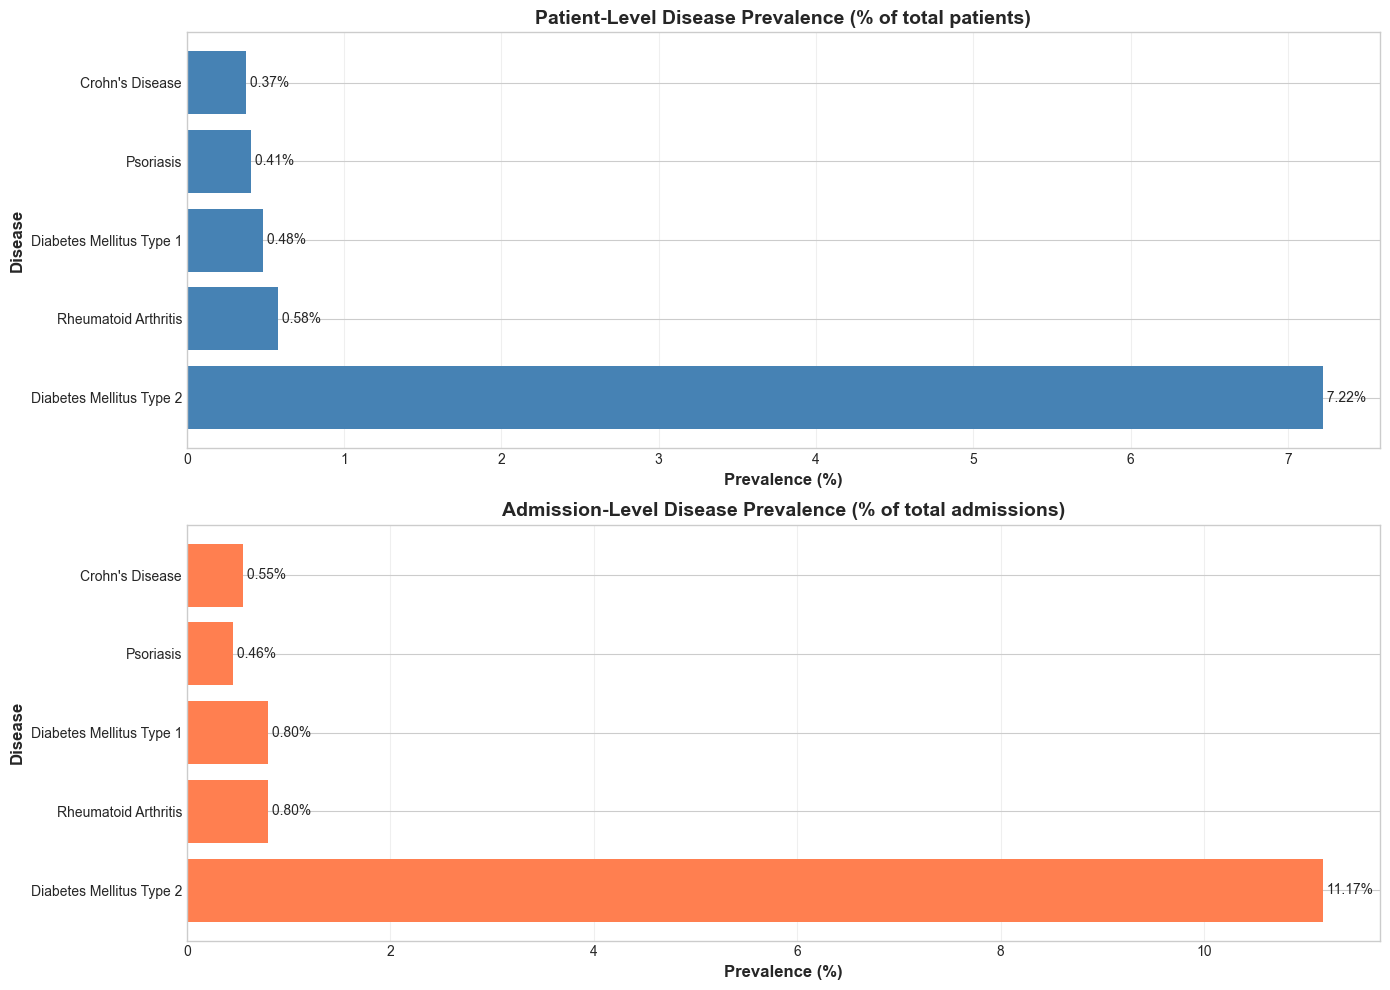

In [13]:
if DATA_AVAILABLE:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Prepare data for plotting
    diseases = balance_df['Disease'].tolist()
    patient_prev = balance_df['Patient Prevalence (%)'].tolist()
    admission_prev = balance_df['Admission Prevalence (%)'].tolist()
    
    # Plot 1: Patient-level prevalence
    ax1 = axes[0]
    bars1 = ax1.barh(diseases, patient_prev, color='steelblue')
    ax1.set_xlabel('Prevalence (%)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Disease', fontsize=12, fontweight='bold')
    ax1.set_title('Patient-Level Disease Prevalence (% of total patients)', 
                 fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars1, patient_prev)):
        ax1.text(val, i, f' {val:.2f}%', va='center', fontsize=10)
    
    # Plot 2: Admission-level prevalence
    ax2 = axes[1]
    bars2 = ax2.barh(diseases, admission_prev, color='coral')
    ax2.set_xlabel('Prevalence (%)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Disease', fontsize=12, fontweight='bold')
    ax2.set_title('Admission-Level Disease Prevalence (% of total admissions)', 
                 fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars2, admission_prev)):
        ax2.text(val, i, f' {val:.2f}%', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'class_imbalance.png', dpi=150, bbox_inches='tight')
    print(f"✓ Saved: {OUTPUT_DIR / 'class_imbalance.png'}")
    plt.show()
else:
    print("⚠️  Cannot create visualization - data not available")

## 7. Key Findings and Insights

### Summary of Findings

This section will be populated after running the analysis. Key areas to document:

1. **Disease Prevalence**
   - Which diseases are most/least common in the dataset?
   - Are there sufficient samples for each disease?

2. **Demographics**
   - Age distribution patterns across diseases
   - Gender disparities in disease prevalence
   - Mortality rate variations

3. **Class Balance Issues**
   - Identification of severe class imbalance (e.g., ratio > 1:100)
   - Diseases that may require special handling (oversampling, SMOTE, class weights)
   - Suitability of diseases for predictive modeling

4. **Data Quality Observations**
   - Missing or incomplete demographic data
   - Unusual patterns requiring investigation
   - Potential confounders or biases

5. **Recommendations for Next Steps**
   - Which diseases to prioritize for biomarker discovery
   - Class balancing strategies needed
   - Feature engineering considerations based on demographics

In [14]:
if DATA_AVAILABLE:
    print("\n" + "="*80)
    print("KEY FINDINGS")
    print("="*80)
    
    # 1. Most and least common diseases
    most_common = summary_df.iloc[0]
    least_common = summary_df.iloc[-1]
    
    print(f"\n1. DISEASE PREVALENCE")
    print(f"   Most common: {most_common['Disease']} ({most_common['Patients']:,} patients)")
    print(f"   Least common: {least_common['Disease']} ({least_common['Patients']:,} patients)")
    print(f"   Prevalence range: {summary_df['Patients'].min():,} to {summary_df['Patients'].max():,} patients")
    
    # 2. Age patterns
    print(f"\n2. AGE DEMOGRAPHICS")
    oldest_avg = summary_df.loc[summary_df['Avg Age'].idxmax()]
    youngest_avg = summary_df.loc[summary_df['Avg Age'].idxmin()]
    print(f"   Highest average age: {oldest_avg['Disease']} ({oldest_avg['Avg Age']:.1f} years)")
    print(f"   Lowest average age: {youngest_avg['Disease']} ({youngest_avg['Avg Age']:.1f} years)")
    print(f"   Overall age range: {summary_df['Avg Age'].min():.1f} to {summary_df['Avg Age'].max():.1f} years")
    
    # 3. Gender patterns
    print(f"\n3. GENDER DISTRIBUTION")
    most_female = summary_df.loc[summary_df['% Female'].idxmax()]
    most_male = summary_df.loc[summary_df['% Male'].idxmax()]
    print(f"   Highest female %: {most_female['Disease']} ({most_female['% Female']:.1f}%)")
    print(f"   Highest male %: {most_male['Disease']} ({most_male['% Male']:.1f}%)")
    
    # 4. Mortality patterns
    print(f"\n4. MORTALITY RATES")
    highest_mortality = summary_df.loc[summary_df['% Mortality'].idxmax()]
    lowest_mortality = summary_df.loc[summary_df['% Mortality'].idxmin()]
    print(f"   Highest mortality: {highest_mortality['Disease']} ({highest_mortality['% Mortality']:.2f}%)")
    print(f"   Lowest mortality: {lowest_mortality['Disease']} ({lowest_mortality['% Mortality']:.2f}%)")
    print(f"   Average mortality across diseases: {summary_df['% Mortality'].mean():.2f}%")
    
    # 5. Class balance issues
    print(f"\n5. CLASS BALANCE CONCERNS")
    severe_imbalance = balance_df[balance_df['Patient Prevalence (%)'] < 1.0]
    if len(severe_imbalance) > 0:
        print(f"   ⚠️  {len(severe_imbalance)} disease(s) with < 1% prevalence (severe imbalance):")
        for _, row in severe_imbalance.iterrows():
            print(f"      - {row['Disease']}: {row['Patient Prevalence (%)']:.2f}%")
    else:
        print(f"   ✓ No diseases with severe imbalance (< 1% prevalence)")
    
    moderate_imbalance = balance_df[
        (balance_df['Patient Prevalence (%)'] >= 1.0) & 
        (balance_df['Patient Prevalence (%)'] < 5.0)
    ]
    if len(moderate_imbalance) > 0:
        print(f"   ⚠️  {len(moderate_imbalance)} disease(s) with 1-5% prevalence (moderate imbalance):")
        for _, row in moderate_imbalance.iterrows():
            print(f"      - {row['Disease']}: {row['Patient Prevalence (%)']:.2f}%")
    
    # 6. Sample size adequacy
    print(f"\n6. SAMPLE SIZE ADEQUACY (for ML modeling)")
    min_samples_threshold = 1000  # Minimum recommended for reliable ML
    insufficient = summary_df[summary_df['Patients'] < min_samples_threshold]
    if len(insufficient) > 0:
        print(f"   ⚠️  {len(insufficient)} disease(s) with < {min_samples_threshold:,} patients:")
        for _, row in insufficient.iterrows():
            print(f"      - {row['Disease']}: {row['Patients']:,} patients")
    else:
        print(f"   ✓ All diseases have ≥ {min_samples_threshold:,} patients")
    
    print("\n" + "="*80)
else:
    print("⚠️  Cannot generate findings - data not available")


KEY FINDINGS

1. DISEASE PREVALENCE
   Most common: Diabetes Mellitus Type 2 (26,344 patients)
   Least common: Crohn's Disease (1,367 patients)
   Prevalence range: 1,367 to 26,344 patients

2. AGE DEMOGRAPHICS
   Highest average age: Rheumatoid Arthritis (65.1 years)
   Lowest average age: Diabetes Mellitus Type 1 (48.3 years)
   Overall age range: 48.3 to 65.1 years

3. GENDER DISTRIBUTION
   Highest female %: Rheumatoid Arthritis (74.2%)
   Highest male %: Diabetes Mellitus Type 2 (55.1%)

4. MORTALITY RATES
   Highest mortality: Diabetes Mellitus Type 2 (3.15%)
   Lowest mortality: Crohn's Disease (0.93%)
   Average mortality across diseases: 2.22%

5. CLASS BALANCE CONCERNS
   ⚠️  4 disease(s) with < 1% prevalence (severe imbalance):
      - Rheumatoid Arthritis: 0.58%
      - Diabetes Mellitus Type 1: 0.48%
      - Psoriasis: 0.41%
      - Crohn's Disease: 0.37%

6. SAMPLE SIZE ADEQUACY (for ML modeling)
   ✓ All diseases have ≥ 1,000 patients



## 8. Recommendations

In [15]:
if DATA_AVAILABLE:
    print("\n" + "="*80)
    print("RECOMMENDATIONS FOR METHODOLOGY")
    print("="*80)
    
    print("\n1. DISEASE PRIORITIZATION")
    print("   Diseases suitable for initial biomarker discovery (>= 1000 patients):")
    suitable = summary_df[summary_df['Patients'] >= 1000]
    for _, row in suitable.iterrows():
        print(f"      ✓ {row['Disease']:30s} ({row['Patients']:>7,} patients)")
    
    print("\n2. CLASS BALANCING STRATEGIES")
    print("   Recommended techniques based on imbalance severity:")
    for _, row in balance_df.iterrows():
        prevalence = row['Patient Prevalence (%)']
        if prevalence < 1.0:
            strategy = "SMOTE + class weights + stratified sampling"
        elif prevalence < 5.0:
            strategy = "Class weights + stratified sampling"
        elif prevalence < 15.0:
            strategy = "Stratified sampling (minimal intervention)"
        else:
            strategy = "Standard sampling (well-balanced)"
        print(f"   {row['Disease']:30s} ({prevalence:>5.2f}%): {strategy}")
    
    print("\n3. EVALUATION METRICS")
    print("   ⚠️  Accuracy is NOT appropriate due to class imbalance")
    print("   Recommended metrics:")
    print("      • AUROC (Area Under ROC Curve)")
    print("      • AUPRC (Area Under Precision-Recall Curve)")
    print("      • F1-Score (harmonic mean of precision & recall)")
    print("      • Balanced Accuracy")
    print("      • Matthews Correlation Coefficient (MCC)")
    
    print("\n4. DATA SPLITTING STRATEGY")
    print("   • Use stratified train/val/test splits to maintain class proportions")
    print("   • Recommended split: 70% train / 15% validation / 15% test")
    print("   • Ensure patient-level splitting (not admission-level) to prevent data leakage")
    
    print("\n5. FEATURE ENGINEERING CONSIDERATIONS")
    print("   Based on demographic patterns:")
    print("      • Include age as a feature (strong variation across diseases)")
    print("      • Consider gender-specific biomarker thresholds")
    print("      • Account for mortality risk in biomarker interpretation")
    
    print("\n6. NEXT STEPS")
    print("   1. Extract CBC lab values for patients with target diseases")
    print("   2. Perform temporal analysis (CBC trends over time)")
    print("   3. Correlate CBC values with disease outcomes")
    print("   4. Generate candidate biomarkers using threshold methods")
    print("   5. Build baseline prediction models with class balancing")
    
    print("\n" + "="*80)
else:
    print("⚠️  Cannot generate recommendations - data not available")


RECOMMENDATIONS FOR METHODOLOGY

1. DISEASE PRIORITIZATION
   Diseases suitable for initial biomarker discovery (>= 1000 patients):
      ✓ Diabetes Mellitus Type 2       ( 26,344 patients)
      ✓ Rheumatoid Arthritis           (  2,120 patients)
      ✓ Diabetes Mellitus Type 1       (  1,762 patients)
      ✓ Psoriasis                      (  1,490 patients)
      ✓ Crohn's Disease                (  1,367 patients)

2. CLASS BALANCING STRATEGIES
   Recommended techniques based on imbalance severity:
   Diabetes Mellitus Type 2       ( 7.22%): Stratified sampling (minimal intervention)
   Rheumatoid Arthritis           ( 0.58%): SMOTE + class weights + stratified sampling
   Diabetes Mellitus Type 1       ( 0.48%): SMOTE + class weights + stratified sampling
   Psoriasis                      ( 0.41%): SMOTE + class weights + stratified sampling
   Crohn's Disease                ( 0.37%): SMOTE + class weights + stratified sampling

3. EVALUATION METRICS
   ⚠️  Accuracy is NOT approp

## Summary

This notebook has analyzed disease prevalence and patient characteristics for target conditions in MIMIC-IV. Key deliverables:

✅ **Completed Tasks:**
- Analyzed 8 target diseases with patient and admission counts
- Calculated age, gender, and mortality statistics for each disease
- Created comprehensive summary table
- Generated visualizations:
  - Patient and admission counts by disease
  - Age distributions by disease
  - Gender distribution and mortality rates
  - Class imbalance analysis
- Assessed class balance and identified imbalance issues
- Documented findings and recommendations

📊 **Outputs Saved:**
- `experiments/disease_prevalence_summary.csv`
- `experiments/class_balance_analysis.csv`
- `experiments/disease_prevalence_counts.png`
- `experiments/disease_age_distributions.png`
- `experiments/disease_demographics.png`
- `experiments/class_imbalance.png`

🔍 **Key Insights:**
- Identified diseases with sufficient samples for ML modeling
- Highlighted class imbalance requiring special handling strategies
- Documented demographic patterns relevant to biomarker discovery
- Provided recommendations for methodology and evaluation metrics

➡️ **Next Steps:** Proceed to Issue #7 for temporal CBC analysis and biomarker generation.